# Example: Backdoor adjustment

## Setup

In [76]:
from typing import Dict, List, Optional, Tuple, Union, TypeVar

import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyro.nn import PyroModule, PyroSample, PyroParam
from pyro.contrib.autoname import scope
from pyro.poutine import condition, reparam

import causal_pyro
from causal_pyro.query.do_messenger import do
from causal_pyro.counterfactual.handlers import Factual, MultiWorldCounterfactual, TwinWorldCounterfactual

## Background: systematically adjusting for observed confounding

Suppose we wish to estimate how
effective a particular treatment $T$ is in producing a desired outcome
$Y$. We assume that we have measurements for both individuals who have 
and have not received treatment, but that we have not conducted a randomized
controlled trial. In these kinds of *observational* settings, there may be
other variables $X$ that influence both $T$ and $Y$, *confounding* the 
causal relationship.

## Example: Evaluating the Impact of Job Training Programs

As a working example, consider the scenario where $T$ represents whether
an individual did ($T=1$) or didn't ($T=0$) participate in a job training
program, and $Y$ represents their earnings 2 years later. In addition to these
measurements, we also gather a collection of covariates $X$ describing 
each individual's attributes, including academic background, previous earnings,
etc. This scenario (and the data we'll use later) come from [@Lalonde]

TODO: pick up here.

In this setting, estimating $P(Y|T)$ would not always accurately characterize
the effect of the $T$ ...
... this conditional distribution may
reflect confounding from other patient attributes $X$ that affect both
the treatment the patient receives and the effectiveness of the
treatment on the outcome.

For example, $P(Y \mid T = 1)$ may place high
mass on positive health outcomes, but only because younger patients are
both more likely to receive treatment and less likely to experience
negative health outcomes.

Robert Lalonde, "Evaluating the Econometric Evaluations of Training Programs", American Economic Review, Vol. 76, pp. 604-620

In [77]:
# Load the data
DATA_URL = "http://www.nber.org/~rdehejia/data/nsw.dta"

data = pd.read_stata(DATA_URL)
data["re75"] = data["re75"] / 1000
data["re78"] = data["re78"] / 1000
df = data[["treat", "education", "age", "re75", "re78"]] 


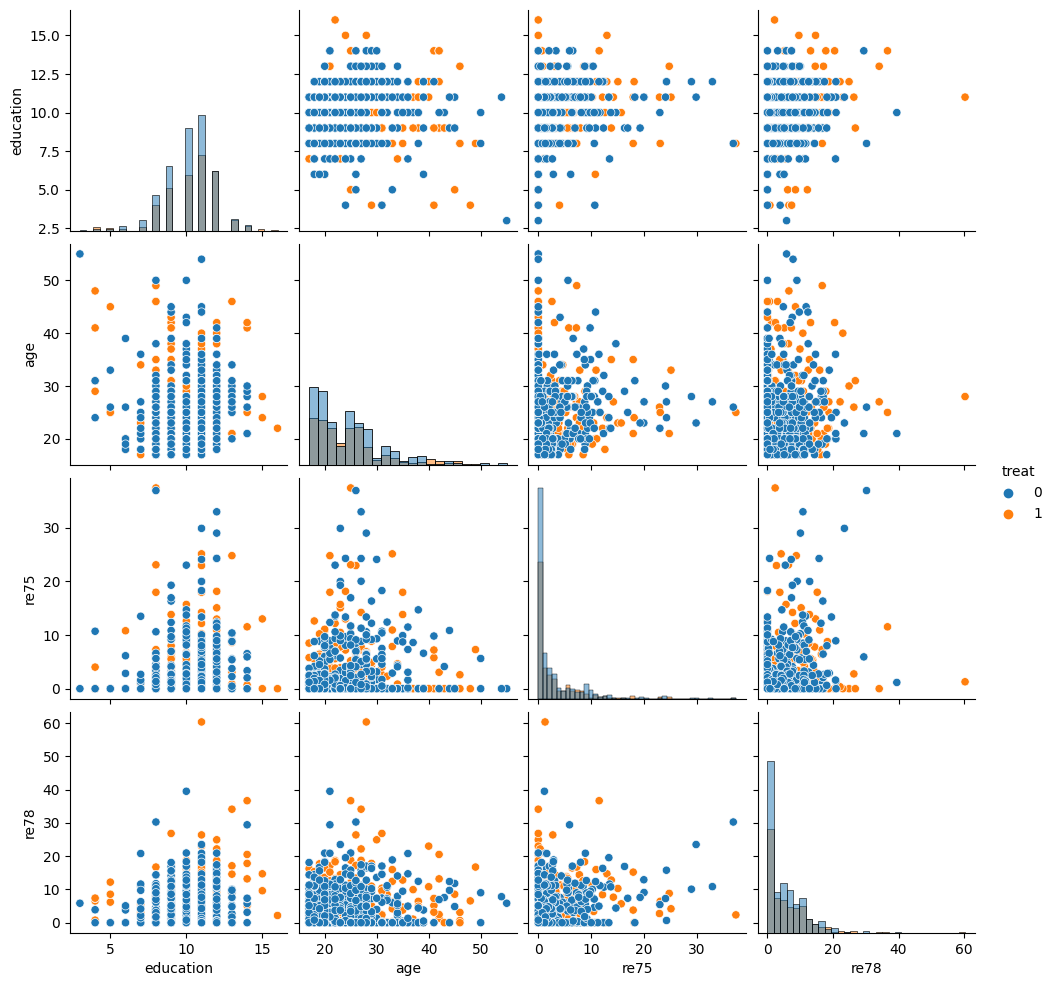

In [78]:
sns.pairplot(df, hue="treat", diag_kind="hist")

In [79]:
treated_individuals = df[df["treat"] == 1]
untreated_individuals = df[df["treat"] == 0]

treated_individuals["re78"].mean() - untreated_individuals["re78"].mean()

0.8863039

In [99]:
covariates_obs = torch.tensor(df[["education", "age", "re75"]].values)
training_obs = torch.tensor(df["treat"].values).float()
earnings_obs = torch.tensor(df["re78"].values)

## Model: causal Bayesian network

The causal assumptions at work can be encoded as a probabilistic program in Pyro. 

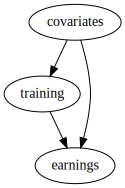

In [118]:
model_args = (torch.rand(3), torch.rand(3), torch.eye(3), torch.rand(3), torch.rand(1), torch.rand(3, 2), torch.rand(2), torch.ones(2))

def backdoor_cbn(loc_covariates, 
                variances_covariates,
                lower_cholesky_covariates, 
                weights_training, 
                bias_training, 
                weights_earnings, 
                bias_earnings, 
                variance_earnings):

    scale_tril = torch.mm(torch.diag(variances_covariates.sqrt()), lower_cholesky_covariates)
    covariates = pyro.sample("covariates", dist.MultivariateNormal(loc_covariates, scale_tril=scale_tril))
    
    logit_training = covariates @ weights_training + bias_training
    training = (pyro.sample("training", dist.Bernoulli(torch.special.expit(logit_training)))).long()
    loc_earnings = pyro.ops.indexing.Vindex(covariates @ weights_earnings)[..., training] + bias_earnings[..., training]
    earnings = pyro.sample("earnings", dist.Normal(loc_earnings, variance_earnings[..., training]))
    
    return covariates, training, earnings

pyro.render_model(backdoor_cbn, model_args=model_args)


From this program, an *intervened* version can be
derived, representing experimental conditions for a patient assigned a
certain treatment $T:=t$.

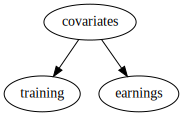

In [119]:
intervened_backdoor_cbn = do(backdoor_cbn, {"training": torch.tensor(0)})

pyro.render_model(intervened_backdoor_cbn, model_args=model_args)

## Query: average treatment effect (ATE)

Under these assumptions, we wish to compute the *average treatment
effect*, $ATE = \mathbb{E}[Y=1|do(T=1)] - \mathbb{E}[Y=1|do(T=0)]$. The
`do` notation indicates that the expectations are taken according to
*intervened* versions of the model, with $T$ set to a particular value.
Note that this is different from conditioning on $T$ in the original
`causal_model`, which assumes $X$ and $T$ are dependent.

As in all of our examples in this paper, the estimand of interest (in
this case, the ATE) can be expressed as a posterior expectation in an
*expanded* probabilistic program. (For the simple example in this
section, this is a standard result, see e.g. @pearl and
@lattimore_2019.) 

Suppose we have a set of measurements
$Y^{(i)}, T^{(i)}, X^{(i)}$ from an observational population
distribution $P(Y, T, X)$. The following probabilistic program encodes a
joint distribution over $\theta$, samples from the causal model, and
hypothetical data corresponding to possible experimental outcomes if
random patients were assigned treatment (1) or no treatment (0).
The ATE is the expected return value of the program after conditioning
our uncertainty of the true model parameters $\theta$ on the measured
observational data.

In [157]:
class BayesianBackdoorATE(PyroModule):
    def __init__(self):
        super().__init__()

    @PyroSample
    def loc_covariates(self):
        loc_prior = torch.tensor([10., 35., 15.])
        variance_prior = loc_prior * 0.5
        return dist.Normal(loc_prior, variance_prior).to_event(1)

    @PyroSample
    def variances_covariates(self):
        return dist.HalfCauchy(torch.ones(3)).to_event(1)
        
    @PyroSample
    def lower_cholesky_covariates(self):
        return dist.LKJCholesky(3, 1)

    @PyroSample
    def weights_training(self):
        loc_prior = torch.zeros(3)
        variance_prior = torch.ones(3) * 10
        return dist.Normal(loc_prior, variance_prior).to_event(1)

    @PyroSample
    def bias_training(self):
        return dist.Normal(torch.tensor([0.]), torch.tensor([10.]))

    @PyroSample
    def weights_earnings(self):
        loc_prior = torch.zeros((3, 2))
        variance_prior = torch.ones((3, 2)) * 10.
        return dist.Normal(loc_prior, variance_prior).to_event(2)
    
    @PyroSample
    def bias_earnings(self):
        loc_prior = torch.zeros(2)
        variance_prior = torch.ones(2) * 10.
        return dist.Normal(loc_prior, variance_prior).to_event(1)
    
    @PyroSample
    def variance_earnings(self):
        return dist.HalfCauchy(torch.ones(2)).to_event(1)

    def forward(self, covariates_obs, training_obs, earnings_obs):
        model_args = (self.loc_covariates, self.variances_covariates, self.lower_cholesky_covariates, self.weights_training, self.bias_training, self.weights_earnings, self.bias_earnings, self.variance_earnings)

        with pyro.plate("data", covariates_obs.shape[0], dim=-1):
            _, _, earnings_obs = condition(data={"covariates": covariates_obs, "training": training_obs, "earnings": earnings_obs})(backdoor_cbn)(*model_args)

        with pyro.contrib.autoname.scope(prefix="treatment"):
            _, _, earnings_treatment = do(actions={"treatment/training": torch.tensor(1.0)})(backdoor_cbn)(*model_args)

        with pyro.contrib.autoname.scope(prefix="control"):
            _, _, earnings_control = do(actions={"control/training": torch.tensor(0.0)})(backdoor_cbn)(*model_args)

        ATE = pyro.deterministic("ATE", earnings_treatment - earnings_control)
        return ATE


bayesian_backdoor_ate = BayesianBackdoorATE()
bayesian_backdoor_ate(covariates_obs, training_obs, earnings_obs)

# pyro.render_model(bayesian_backdoor_ate, model_args=(covariates_obs, training_obs, earnings_obs))

tensor(126.3280)

### A different approach

In [158]:
class BayesianBackdoorSCM(BayesianBackdoorATE):

    def forward(self, age_obs, training_obs, earnings_obs):

        n = age_obs.shape[0]

        extended_model = do(actions={"training":0})(
                            do(actions={"training": 1})(
                                pyro.plate("data", n, dim=-1)(
                                        condition(data={"covariates": covariates_obs, "training": training_obs, "earnings": earnings_obs})(
                                                backdoor_cbn))))

        with MultiWorldCounterfactual(-2):
            model_args = (self.loc_covariates, self.variances_covariates, self.lower_cholesky_covariates, self.weights_training, self.bias_training, self.weights_earnings, self.bias_earnings, self.variance_earnings)
            _, _, earnings = extended_model(*model_args)
            earnings_treatment = earnings[..., 1, 0, :]
            earnings_control = earnings[..., 0, 1, :]
            ATE = pyro.deterministic("ATE", torch.sum(earnings_treatment - earnings_control, dim=-1) / n)
        return ATE

bayesian_backdoor_ate_scm = BayesianBackdoorSCM()
bayesian_backdoor_ate_scm(covariates_obs, training_obs, earnings_obs)
# pyro.render_model(bayesian_backdoor_ate_scm, model_args=(covariates_obs, training_obs, earnings_obs))

tensor(454.9516)

## Setting up MAP + Enumeration Inference

In [159]:
from pyro.infer.autoguide.guides import AutoGuideList, AutoDelta, AutoContinuous
from pyro.infer.autoguide.structured import AutoStructured
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
import pyro.poutine as poutine

In [163]:
guide = AutoDelta(poutine.block(bayesian_backdoor_ate, hide=['treatment/training', 'control/training']))

In [164]:
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(bayesian_backdoor_ate, guide, adam, loss=TraceEnum_ELBO())

In [165]:
num_iterations = 1000

pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(covariates_obs, training_obs, earnings_obs)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 2680.0506
[iteration 0101] loss: 79.9323
[iteration 0201] loss: 41.3800
[iteration 0301] loss: 31.2656
[iteration 0401] loss: 18.6640
[iteration 0501] loss: 16.7856
[iteration 0601] loss: 15.7196
[iteration 0701] loss: 15.0349
[iteration 0801] loss: 14.5558
[iteration 0901] loss: 14.2025


#TODO
- Set up Autoguide
- Run SVI with automatically constructed guide
- plot loss curves
- plot distribution over ATE